Model 3 RNN 

In [3]:
%load_ext autoreload

%autoreload 2

In [97]:
import preproc_RNN_LSTM
import pandas as pd
import plot_evaluate_models
import matplotlib.pyplot as plt
from metrics import get_baseline_data
import numpy as np
import math
import tensorflow
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import TimeDistributed, Dropout, BatchNormalization
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import RobustScaler
from baseline import get_baseline_actual, get_baseline_predictions, forecast_accuracy

# Import imput data

In [5]:
data = preproc_RNN_LSTM.get_baseline_data("raw_data/preproc_data_rate.csv")


# Set parameters

In [210]:
n_sequences=4000
length=150
prediction_horizon = 31

# Modelling

## set training and test set

In [211]:
X_train, y_train, X_test, y_test = preproc_RNN_LSTM.get_train_test(data,n_sequences,length, prediction_horizon)

In [231]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4000, 119, 30), (4000, 31, 30), (1000, 119, 30), (1000, 31, 30))

## define model

In [212]:
#model1 = preproc_RNN_LSTM.model(n_sequences, length-prediction_horizon, 30, prediction_horizon)

model1 = models.Sequential()
model1.add(layers.LSTM(128, return_sequences=False, activation="tanh", \
    input_shape = (length-prediction_horizon, 30)))
model1.add(layers.RepeatVector(prediction_horizon))
#model.add(Dropout(0.4))
model1.add(layers.LSTM(40, return_sequences=True, activation="tanh"))
# added 
#model.add(BatchNormalization())
#model.add(Dropout(0.4))
model1.add(layers.TimeDistributed(layers.Dense(30,"relu")))
model1.compile(loss="mse",
            optimizer="rmsprop")

## train model

In [213]:
#preproc_RNN_LSTM.fit_model(X_train, y_train, model1)
es = EarlyStopping(monitor='val_loss', verbose=1, patience=20, restore_best_weights=True)
hist = model1.fit(X_train, y_train, 
                 callbacks=[es],
                 epochs = 2000,
                 validation_split =0.3, 
                 batch_size=16
                )

Epoch 1/2000
175/175 [==============================] - 9s 42ms/step - loss: 0.0461 - val_loss: 0.0483
Epoch 2/2000
175/175 [==============================] - 6s 36ms/step - loss: 0.0435 - val_loss: 0.0471
Epoch 3/2000
175/175 [==============================] - 8s 46ms/step - loss: 0.0434 - val_loss: 0.0487
Epoch 4/2000
175/175 [==============================] - 7s 40ms/step - loss: 0.0420 - val_loss: 0.0450
Epoch 5/2000
175/175 [==============================] - 7s 38ms/step - loss: 0.0403 - val_loss: 0.0434
Epoch 6/2000
175/175 [==============================] - 7s 37ms/step - loss: 0.0395 - val_loss: 0.0442
Epoch 7/2000
175/175 [==============================] - 8s 45ms/step - loss: 0.0384 - val_loss: 0.0420
Epoch 8/2000
175/175 [==============================] - 8s 47ms/step - loss: 0.0378 - val_loss: 0.0407
Epoch 9/2000
175/175 [==============================] - 7s 39ms/step - loss: 0.0382 - val_loss: 0.0407
Epoch 10/2000
175/175 [==============================] - 7s 39ms/step - l

Epoch 80/2000
175/175 [==============================] - 7s 39ms/step - loss: 0.0219 - val_loss: 0.0244
Epoch 81/2000
175/175 [==============================] - 7s 38ms/step - loss: 0.0216 - val_loss: 0.0238
Epoch 82/2000
175/175 [==============================] - 7s 37ms/step - loss: 0.0221 - val_loss: 0.0243
Epoch 83/2000
175/175 [==============================] - 6s 36ms/step - loss: 0.0214 - val_loss: 0.0256
Epoch 84/2000
175/175 [==============================] - 6s 36ms/step - loss: 0.0209 - val_loss: 0.0274
Epoch 85/2000
175/175 [==============================] - 7s 39ms/step - loss: 0.0213 - val_loss: 0.0268
Epoch 86/2000
175/175 [==============================] - 6s 37ms/step - loss: 0.0210 - val_loss: 0.0216
Epoch 87/2000
175/175 [==============================] - 7s 38ms/step - loss: 0.0209 - val_loss: 0.0243
Epoch 88/2000
175/175 [==============================] - 6s 36ms/step - loss: 0.0212 - val_loss: 0.0274
Epoch 89/2000
175/175 [==============================] - 6s 37ms

# Check outputs

## Check validation set

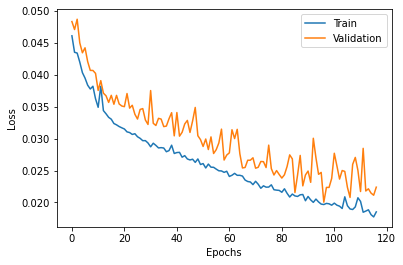

In [214]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'])
plt.show()

## Check predicted vs actual on test set

/Users/desireepetrilli/Documents/event-forecast-rio/baseline.py:19: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  baseline_mean = baseline_data.mean().to_frame().T


Prediction MSE (computed on test set):0.08847010642529601
Baseline MSE (computed on test set):0.04010388681705765


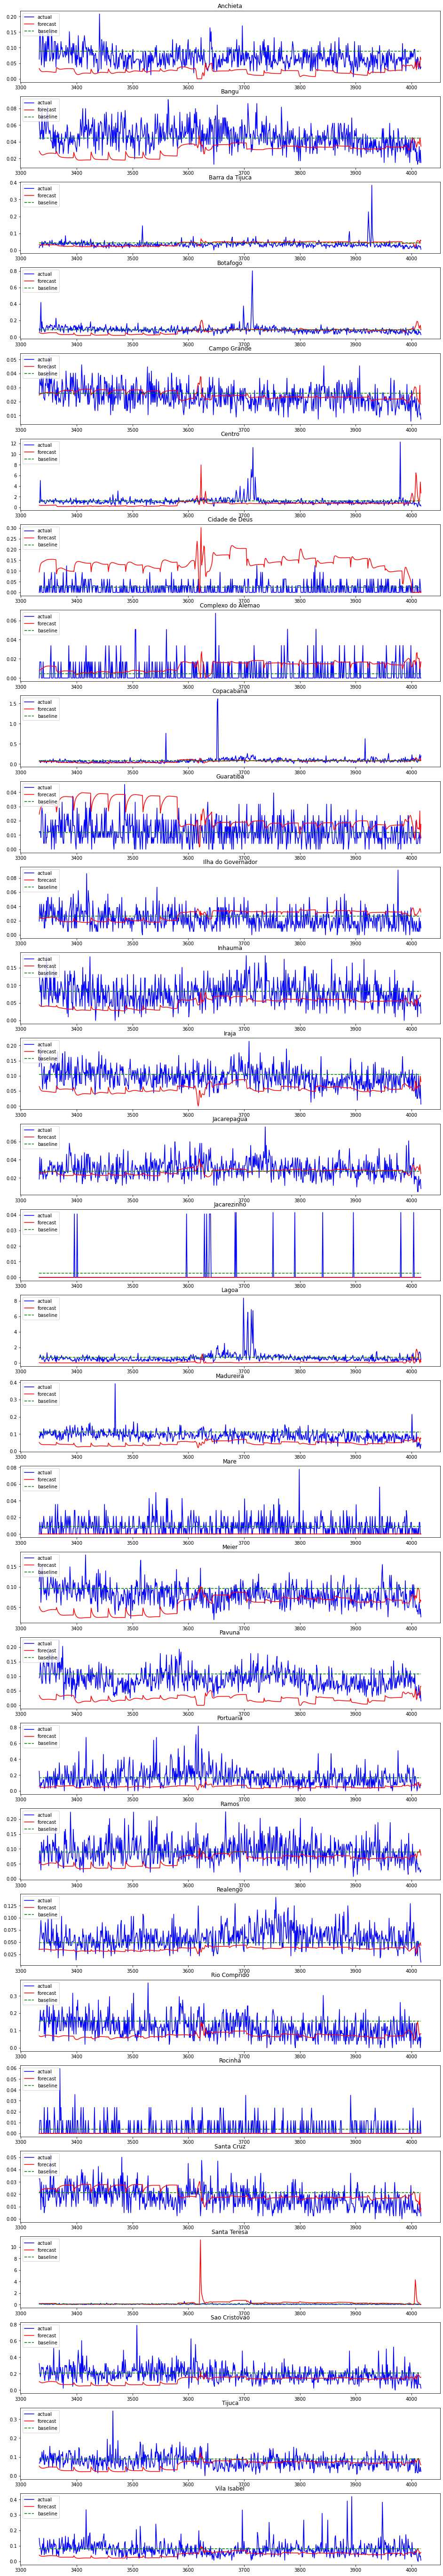

In [215]:
y_pred_df = plot_evaluate_models.compute_plot_pred_multi(data,hist.model,length, prediction_horizon)

# Compare to baseline

In [123]:
actual = get_baseline_actual(data).drop(columns="Date")

In [124]:
baseline = get_baseline_predictions(data)

In [125]:
forecast_accuracy(actual,baseline)

{'mse': 0.05266306588502226,
 'mae': 0.049240814256642985,
 'corr': 0.9999999999999999}

# Check function


In [216]:
data_wo_date = data.drop(columns="Date")
len_ = int(0.8*data_wo_date.shape[0])
data_test = data_wo_date[len_:]


In [217]:
int((804-(length-prediction_horizon))/prediction_horizon)+1

23

In [226]:
i = 0
print(f"input starts at {i*prediction_horizon}")
print(f"input ends at {i*prediction_horizon+(length-prediction_horizon)} (not incl)")

data_test_temp = data_wo_date[i*prediction_horizon:i*prediction_horizon+(length-prediction_horizon)]
data_test_temp = np.array(data_test_temp)
data_test_temp = data_test_temp.reshape(1,(length-prediction_horizon),30)
y_pred_temp_0 = model1.predict(data_test_temp).tolist()[0]
print(f"output starts at {i*prediction_horizon+(length-prediction_horizon)}")
print(f"output ends at {i*prediction_horizon+(length-prediction_horizon) +31} (not incl)")
#y_pred = y_pred + y_pred_temp
y_pred_temp_0_df = pd.DataFrame(y_pred_temp_0, columns = data_wo_date.columns)
#y_pred_temp_0_df

input starts at 0
input ends at 119 (not incl)
output starts at 119
output ends at 150 (not incl)


In [227]:
i = 1
print(f"input starts at {i*prediction_horizon}")
print(f"input ends at {i*prediction_horizon+(length-prediction_horizon)} (not incl)")

i*prediction_horizon+(length-prediction_horizon)
data_test_temp = data_wo_date[i*prediction_horizon:i*prediction_horizon+(length-prediction_horizon)]
data_test_temp = np.array(data_test_temp)
data_test_temp = data_test_temp.reshape(1,(length-prediction_horizon),30)

y_pred_temp_1 = model1.predict(data_test_temp).tolist()[0]
print(f"output starts at {i*prediction_horizon+(length-prediction_horizon)}")
print(f"output ends at {i*prediction_horizon+(length-prediction_horizon) +31} (not incl)")

y_pred_temp_1_df = pd.DataFrame(y_pred_temp_1, columns = data_wo_date.columns)
#y_pred_temp_1_df

input starts at 31
input ends at 150 (not incl)
output starts at 150
output ends at 181 (not incl)


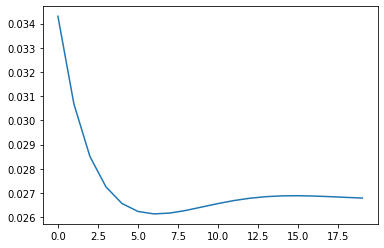

In [201]:
plt.plot(y_pred_temp_0_df.Anchieta)

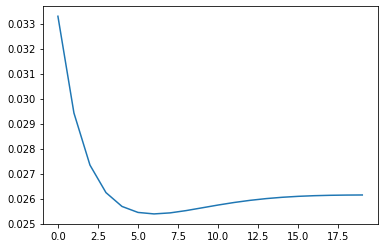

In [202]:
plt.plot(y_pred_temp_1_df.Anchieta)

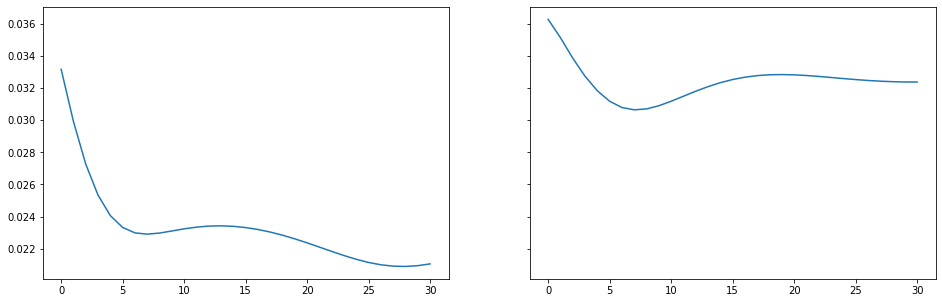

In [223]:
fig, ax = plt.subplots(1,2,figsize=(16,5), sharey=True)
ax[0].plot(y_pred_temp_0_df.Anchieta)
ax[1].plot(y_pred_temp_1_df.Anchieta)

